In [1]:
#! /usr/bin/env python3
import os
import time
from xml.sax.xmlreader import InputSource
import cv2
import numpy as np
import tensorrt as trt
from log import timer, logger
import trt_common
import rospy
import pycuda.driver as cuda
import pycuda.autoinit
from multiprocessing import Process


TRT_LOGGER = trt.Logger(trt.Logger.WARNING)
trt_runtime = trt.Runtime(TRT_LOGGER)

class TrtMLSD(object):
    """TrtMLSD class encapsulates things needed to run TRT MLSD."""
    def _load_engine(self):
        load_trt = timer("Load TRT Engine")
        with open(self.engine_path, 'rb') as f:
            engine_data = f.read()
        engine = trt_runtime.deserialize_cuda_engine(engine_data)
        load_trt.end()
        return engine
    
    def __init__(self,engine_path,input_shape,cuda_ctx=None):
        self.engine_path=engine_path
        self.input_shape=input_shape
        self.cuda_ctx = cuda.Device(0).make_context()
        self.engine=self._load_engine()
        self.context = self.engine.create_execution_context()
        self.inputs, self.outputs, self.bindings, self.stream = trt_common.allocate_buffers(self.engine)

    def __del__(self):
        """Free CUDA memories."""
        del self.outputs
        del self.inputs
        del self.stream

    def detect(self,image,score_thr, dist_thr):
        batch_image,h_ratio,w_ratio=self.resize_img(image)

        # Set host input to the image. The do_inference() function
        # will copy the input to the GPU before executing.
        self.inputs[0].host = np.ascontiguousarray(batch_image)

        # if self.cuda_ctx:
        self.cuda_ctx.push()

        self.bindings = [int(i) for i in self.bindings]

        context = self.context
        bindings = self.bindings
        inputs = self.inputs
        outputs = self.outputs
        stream = self.stream

        infer_trt = timer("TRT Inference")
        # Run inference.
        trt_outputs = trt_common.do_inference(context, bindings=bindings, inputs=inputs, outputs=outputs, stream=stream)
        
        infer_trt.end()

        del context

        # if self.cuda_ctx:
        self.cuda_ctx.pop()
        lines=pred_lines(trt_outputs,h_ratio, w_ratio,score_thr,dist_thr)
        return lines
       


      

    def resize_img(self,image):
        h, w, _ = image.shape
        h_ratio, w_ratio = [h / self.input_shape[0], w / self.input_shape[1]]
        resized_image = np.concatenate([cv2.resize(image, (self.input_shape[0], self.input_shape[1]), interpolation=cv2.INTER_AREA), np.ones([self.input_shape[0], self.input_shape[1], 1])], axis=-1)
        batch_image = np.expand_dims(resized_image, axis=0).astype('float32')
        #print(batch_image.shape)
        return batch_image,h_ratio, w_ratio





def pred_lines(trt_outputs,h_ratio, w_ratio,score_thr=0.10, dist_thr=20.0):
    pts = trt_outputs[1].reshape(200,2)
    pts_score = trt_outputs[0]
    vmap = trt_outputs[2].reshape(256,256,4)
    start = vmap[:,:,:2]
    end = vmap[:,:,2:]
    dist_map = np.sqrt(np.sum((start - end) ** 2, axis=-1))

    segments_list = []
    for center, score in zip(pts, pts_score):
        y, x = center
        distance = dist_map[y, x]
        if score > score_thr and distance > dist_thr:
            disp_x_start, disp_y_start, disp_x_end, disp_y_end = vmap[y, x, :]
            x_start = x + disp_x_start
            y_start = y + disp_y_start
            x_end = x + disp_x_end
            y_end = y + disp_y_end
            segments_list.append([x_start, y_start, x_end, y_end])
    
    lines = 2 * np.array(segments_list) # 256 > 512
    lines[:,0] = lines[:,0] * w_ratio
    lines[:,1] = lines[:,1] * h_ratio
    lines[:,2] = lines[:,2] * w_ratio
    lines[:,3] = lines[:,3] * h_ratio
    return lines

In [37]:
#! /usr/bin/env python3

'''!
 \copyright Confidential property of Cyberworks Robotics Inc.
 Copyright 2022. Do not distribute. Do not copy.
'''

'''!
 @file
 
 Code for finding bestline in ceiling for drift detection

 @author Cheng, Yesibao, Mahmoud Nasr
'''

'''!
  The class detects all line featrues from camera images and pick the best lines for 
  each frame.
  
  The class detect all lines in each frame and store their info as 
  [point1.x, point1.y, point2.x, point2.y, width, angle, length, credit]
  The candidates of the best line are within the range [angle-tolerance,angle+tolerance]
'''

#1280*720 30 frames/s
from curses import wrapper
import cv2
import engine as eng
import numpy as np
import tensorrt as trt
from log import timer, logger
import trt_common
import matplotlib.pyplot as plt

class MLSDBestLineDetection(object):
    
    def __init__(self,angle=90,tolerance=5):
        ## A flag that indicates if the output image shall be drawn 
        self.draw_img = True
        self.angle = angle
        self.range = tolerance      # angle error tolerance
        self.angle_weight=0.5
        self.width_weight=3
        self.length_weight=0.1
                                  # postion weight
        #self.minWidth= 3  No more considering width
        self.minLength = 10



    def setAngle(self,new_angle):
        self.angle=new_angle
    
    def setTolerance (self, new_tolerance):
        self.range=new_tolerance
        
    # pre-process the input image by resizing, grayscaling, lsding and caluclating the line segments' angles, lengths and credits  
    def processSegments(self, segments):
        
        # Resize Image
        # batch_image,h_ratio,w_ratio = self.resize_img(input_image)

        # LSD
        # [point1.x, point1.y, point2.x, point2.y, width]
        # segments = wrapper_for_mlsd(batch_image,self.trt_engine,h_ratio,w_ratio,self.score_thr,self.dist_thr)

        widths=np.ones((segments.shape[0],1)) # MLSD does not detect width element, so add a place holder
        segments=np.append(segments,widths,axis=1)
        if segments.shape[0]==0:
            lines_info=segments.reshape(0,8)
        else:
            angles = self.line_angle(segments)
            lengths = self.line_length(segments)
            lines_info = np.append(segments, angles, axis=1)
            lines_info = np.append(lines_info, lengths, axis=1)

            credits = self.line_credit(lines_info,self.angle_weight,self.width_weight,self.length_weight)
            lines_info = np.append(lines_info, credits, axis=1)
            #print("line_info shape:",lines_info.shape)
            #print(type(lines_info))
        return lines_info

    

    def bestline_picker(self, input_image,lines_info):
        #print(type(lines_info))

        # [point1.x, point1.y, point2.x, point2.y, width, angle, length, credit]
        copy=np.copy(input_image)
        bestline = self.pick_bestline(lines_info)
        if bestline[6]!=0:
            
            output_image = self.draw_bestline(copy, bestline)
            #draw_str(output_image, (20, 20), 'Angle_drift: %d' % (bestline[5] - self.angle) + ' Length: %d' % bestline[6])
            #draw_str(output_image, (20, 40), 'delta_x: %d' % (bestline[0] - bestline[2]))
            #print("Deata x =", bestline[0] - bestline[2])  
        else:
            output_image = input_image
        return bestline, output_image, lines_info


    # Caculation methods of line lengths, angles and credits
    def line_angle(self,segments):
        rows = segments.shape[0]
        x1, y1, x2, y2 = segments[:,0],segments[:,1],segments[:,2],segments[:,3]
        angles = np.degrees(np.arctan2(y1 - y2, x2 - x1))  # y axis reverses in pixel coordinate, so y1-y2
        angles=np.where(angles<0,angles+180,angles)
        return angles.reshape(rows, -1)



    def line_length(self,segments):
        rows = segments.shape[0]
        point1 = segments[:,0:2]
        point2 = segments[:,2:4]
        lengths=np.linalg.norm(point2-point1,axis=-1) # apply L2 norm to each row
        return lengths.reshape(rows, -1)


    def line_credit(self,lines_info,angle_weight, width_weight, length_weight):
        rows = lines_info.shape[0]
        credits = angle_weight*lines_info[:,5]+width_weight*lines_info[:,4]+length_weight*lines_info[:,6]
        return credits.reshape(rows,-1)


    def draw_bestline(self,img, lines_info):
        coordinates = lines_info[0:4].reshape([2, 2]).astype(int)
        best_img = cv2.line(img, (coordinates[0][0], coordinates[0][1]), (coordinates[1][0], coordinates[1][1]),
                            (255, 0, 0), 3)
        return best_img


    def pick_bestline(self, lines_info):  # pick the line with the most credits within valid range
        # valid range: theta-range<=angle<= theta+range, width>=minWidth, length>=minLength
        #print(type(lines_info))
        #print(lines_info.shape)
        closelines=lines_info[(lines_info[:,5] >= (self.angle - self.range)) & (lines_info[:, 5] <= (self.angle + self.range)) & (lines_info[:,6]>=self.minLength)] 
        #print(closelines)
        if closelines.size == 0: # if there is no line within the range
            #flag = False
            return np.zeros(8)
        else:
            #flag = True
            index_close=np.argmax(closelines[:, 7])
            index=np.where(np.all(lines_info==closelines[index_close],axis=1))               
            return lines_info[index[0][0]]
        
    def pick_sameline(self, prev_bestline, lines_info):
        dists=[]
        # Candidate lines are the lines whose angles are in (angle-range, angle+range) and lenghths >minLength
        candidate_lines=lines_info[(lines_info[:, 5] >= (self.angle - self.range)) & (lines_info[:, 5] <= (self.angle + self.range))&(lines_info[:,6]>=self.minLength)]
        rows = candidate_lines.shape[0]
        print("number of candidate lines:",rows)
        #print(prev_bestline[:2].astype(int))
        
        for i in candidate_lines:
            # distance between lower points of candidate lines and previous best line
            distance=[np.linalg.norm((i[:2] if i[1]>i[3] else i[2:4]) - (prev_bestline[:2] if prev_bestline[1]> prev_bestline[3] else prev_bestline[2:4]))]
            #dist_list+=[np.linalg.norm(i[:2] - prev_bestline[2:4])] 
            #dist_list+=[np.linalg.norm(i[2:4] - prev_bestline[:2])] 
            #dist_list+=[np.linalg.norm(i[2:4] - prev_bestline[2:4])] 
            #distance= min(dist_list)
            #print(distance)
            dists.append(distance)
        dists=np.array(dists).reshape(rows, -1)
        
        candidate_lines=np.append(candidate_lines,dists,axis=1)
       
        # [point1.x, point1.y, point2.x, point2.y, width, angle, length, credit, dist_to_prev_bestline]
        closelines=candidate_lines[(candidate_lines[:,8]<60)] 
        #print(closelines.astype(int))
        if closelines.size==0:
            print("No same line!")
            print("Candidate lines info with dists:")
            print(candidate_lines.astype(int))
            return np.zeros(8), True
        else:
            index_nearest=np.abs(closelines[:,5]-prev_bestline[5]).argmin()
            index=np.where(np.all(candidate_lines==closelines[index_nearest],axis=1))
            return candidate_lines[index[0][0]], False




In [4]:
import sys
import glob
import cv2
import numpy as np
import natsort
import matplotlib.pyplot as plt
import time
imgfiles=[]

for file in sorted(glob.glob("/home/cheng/Downloads/whiteline_images/frame*.jpg")):
    imgfiles.append(file)

imgfiles=natsort.natsorted(imgfiles)
print(len(imgfiles))


137


In [5]:
angle=90
tolerance=5
dist_thr=20
score_thr=0.25
engine_path = "/home/cheng/catkin_ws/src/ceiling_drift_detector/src/ceiling_drift_detector/mlsd_512_fp16.trt"
input_shape=[512,512]
trt_mlsd=TrtMLSD(engine_path,input_shape)
   

-------------------------------------------------- 

Load TRT Engine... Done (6.34662s)



In [6]:
def draw_lines(img_input,lines):
    img_output = img_input.copy()
    

    # draw lines
    
    for line in lines:
        x_start, y_start, x_end, y_end = [int(val) for val in line]
        cv2.line(img_output, (x_start, y_start), (x_end, y_end), [0,255,255], 2)

    return img_output

frame 0
-------------------------------------------------- 

TRT Inference... Done (1.62840s)

Line Segments detected!
(24, 4)


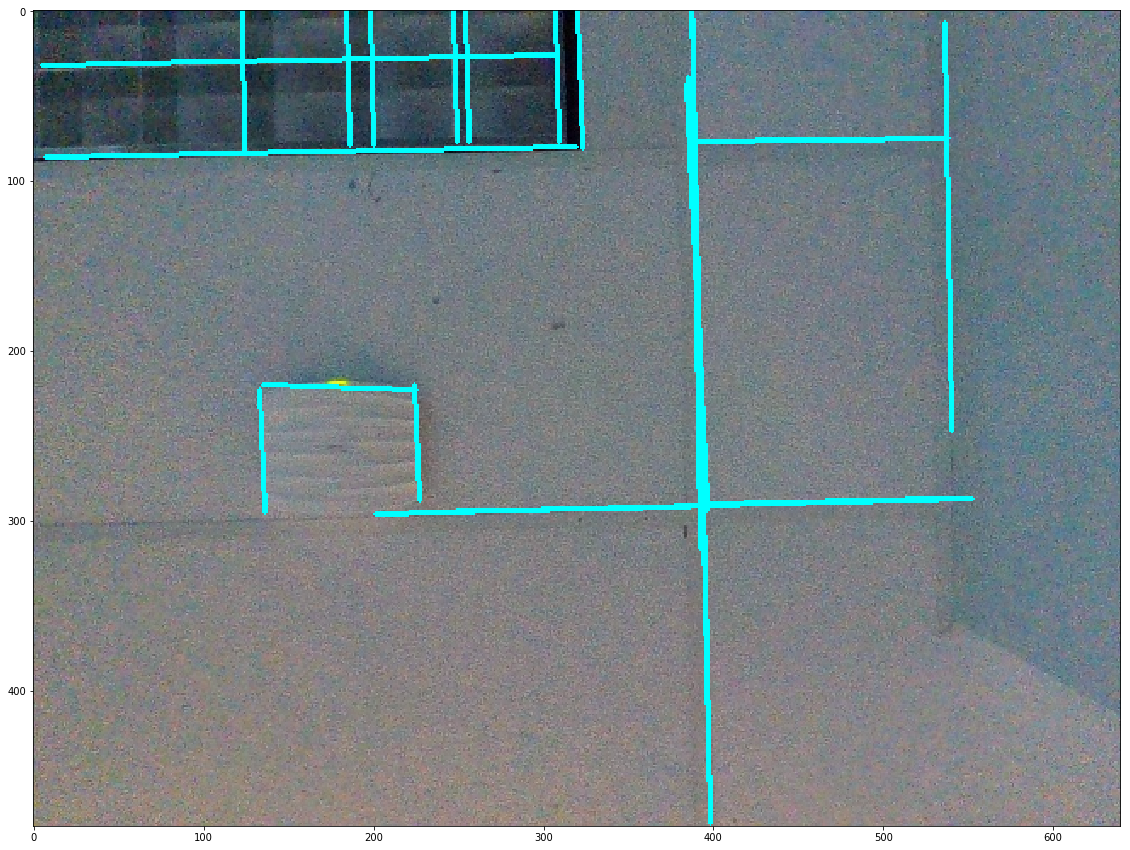

Best line detected:
[387.69134521 -30.20507812 392.88421631 316.16455078   1.
  90.85893012 346.40855321  83.07032038]


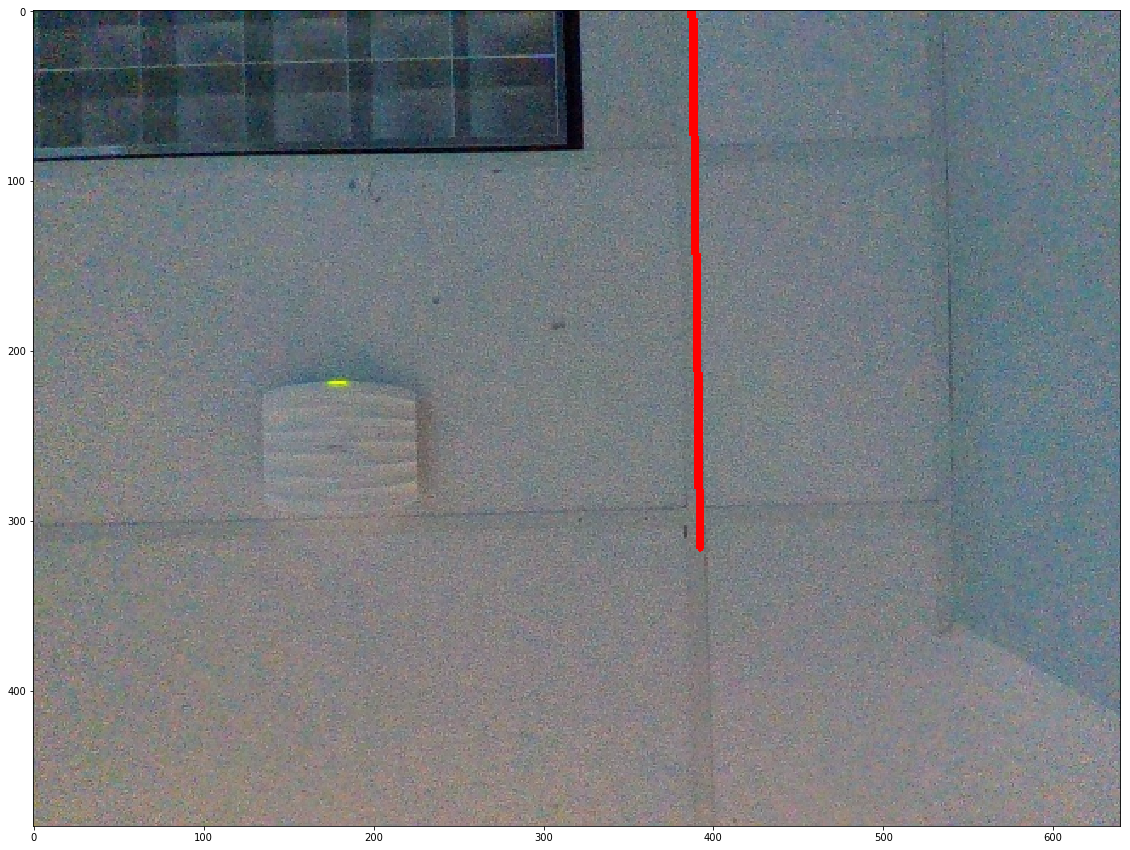

Press Enter to continue...
frame 1
-------------------------------------------------- 

TRT Inference... Done (0.17087s)

Line Segments detected!
(30, 4)


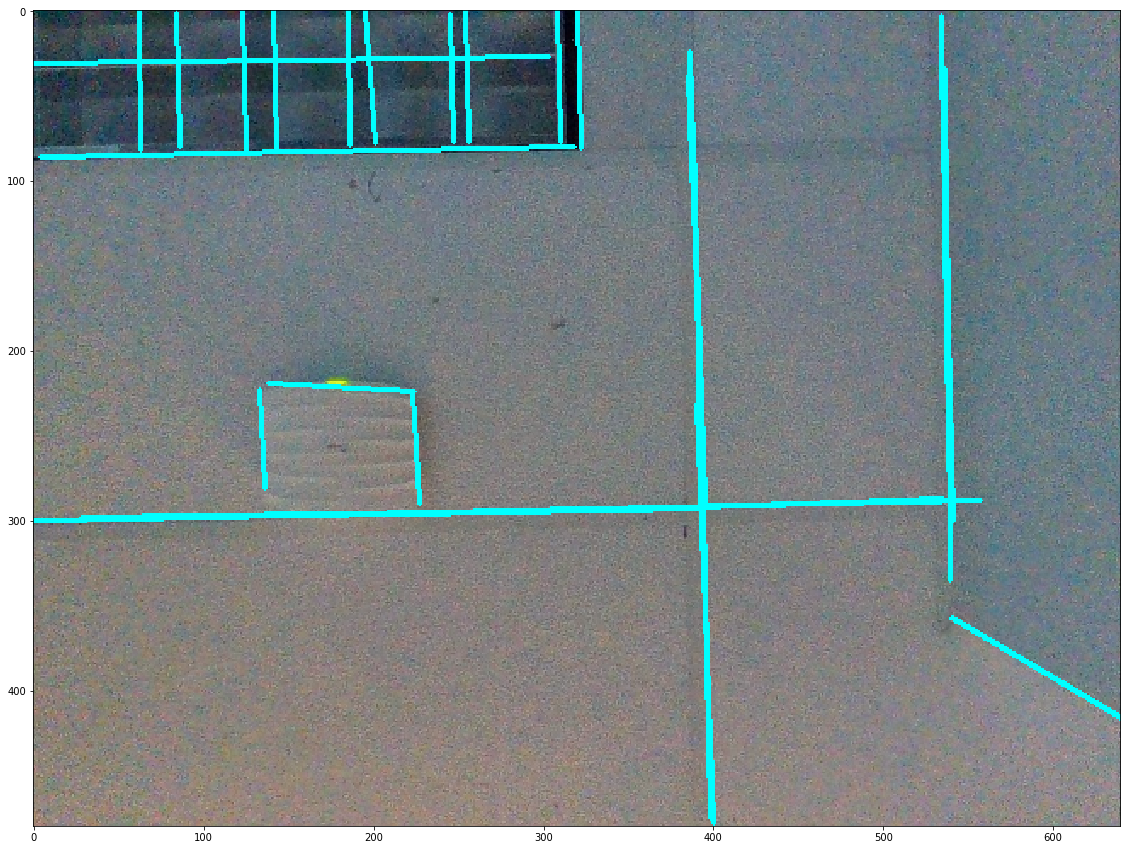

number of candidate lines: 21
Tracking the same best line...


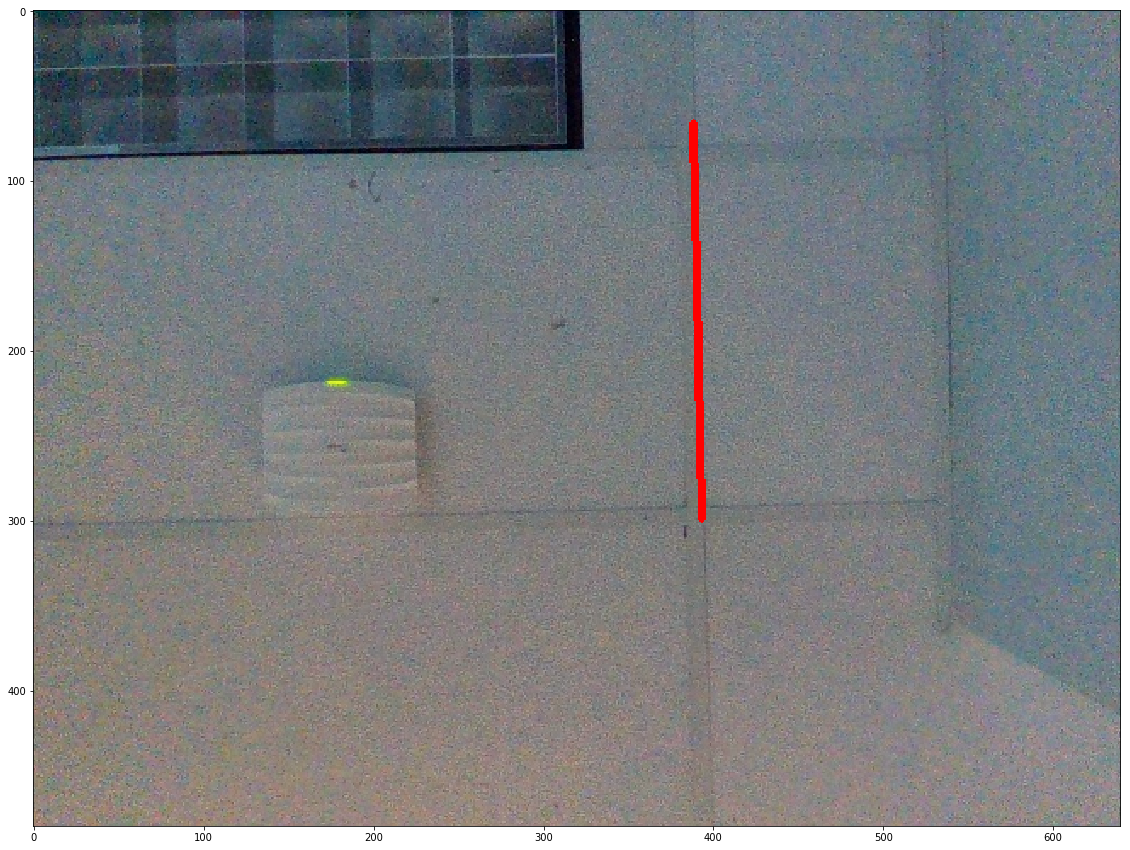

Press Enter to continue...
frame 2
-------------------------------------------------- 

TRT Inference... Done (0.13768s)

Line Segments detected!
(30, 4)


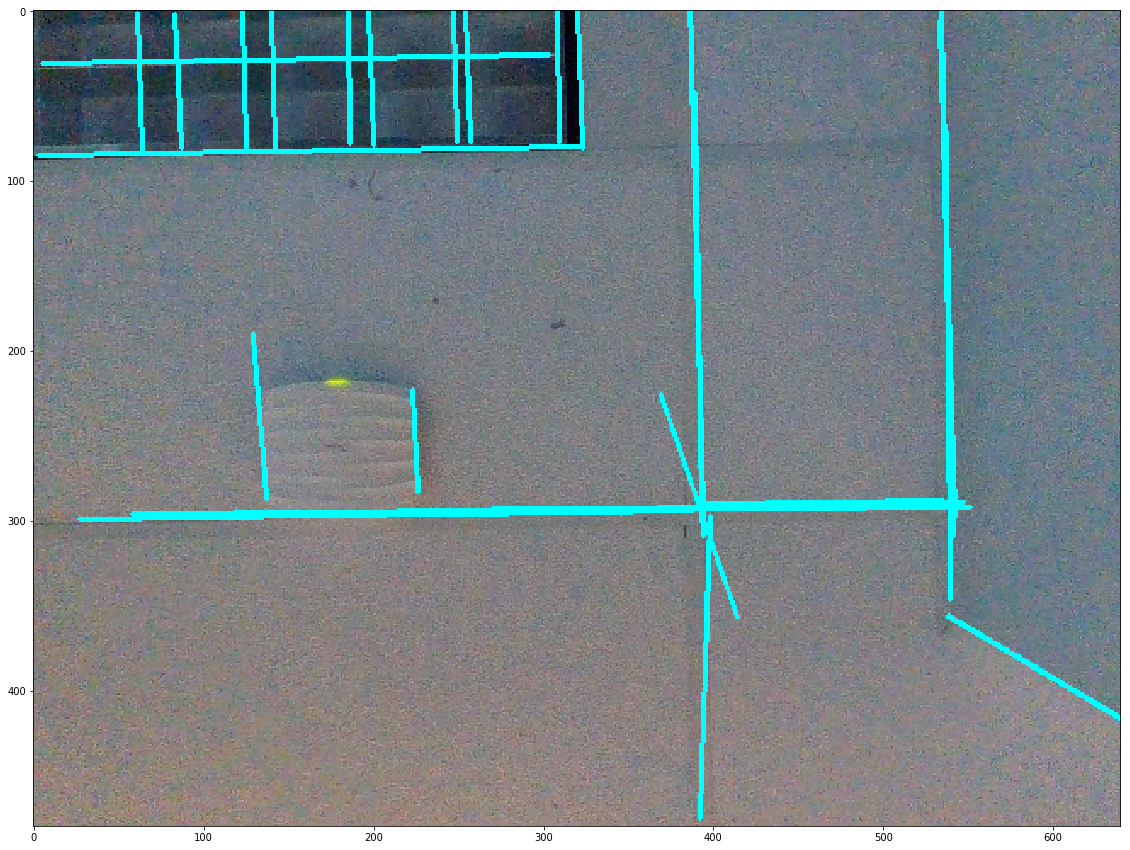

number of candidate lines: 20
Tracking the same best line...


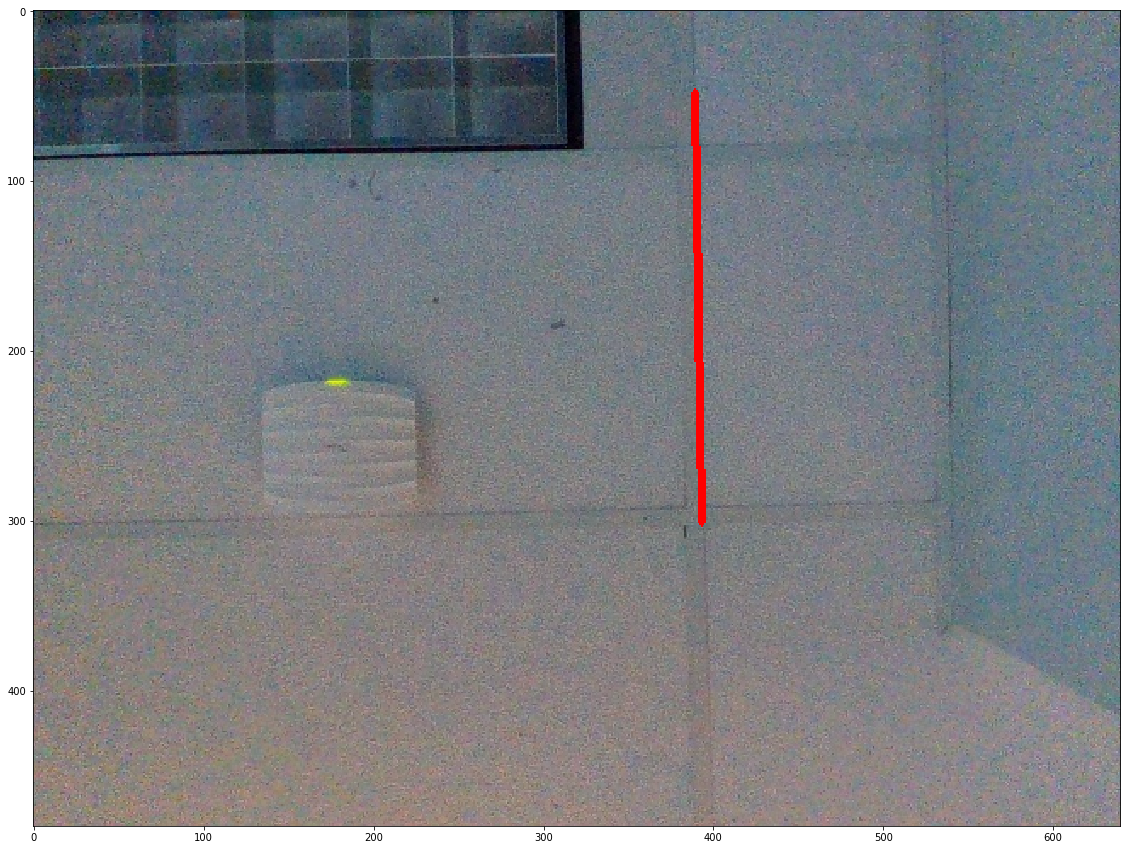

Press Enter to continue...
frame 3
-------------------------------------------------- 

TRT Inference... Done (0.19870s)

Line Segments detected!
(39, 4)


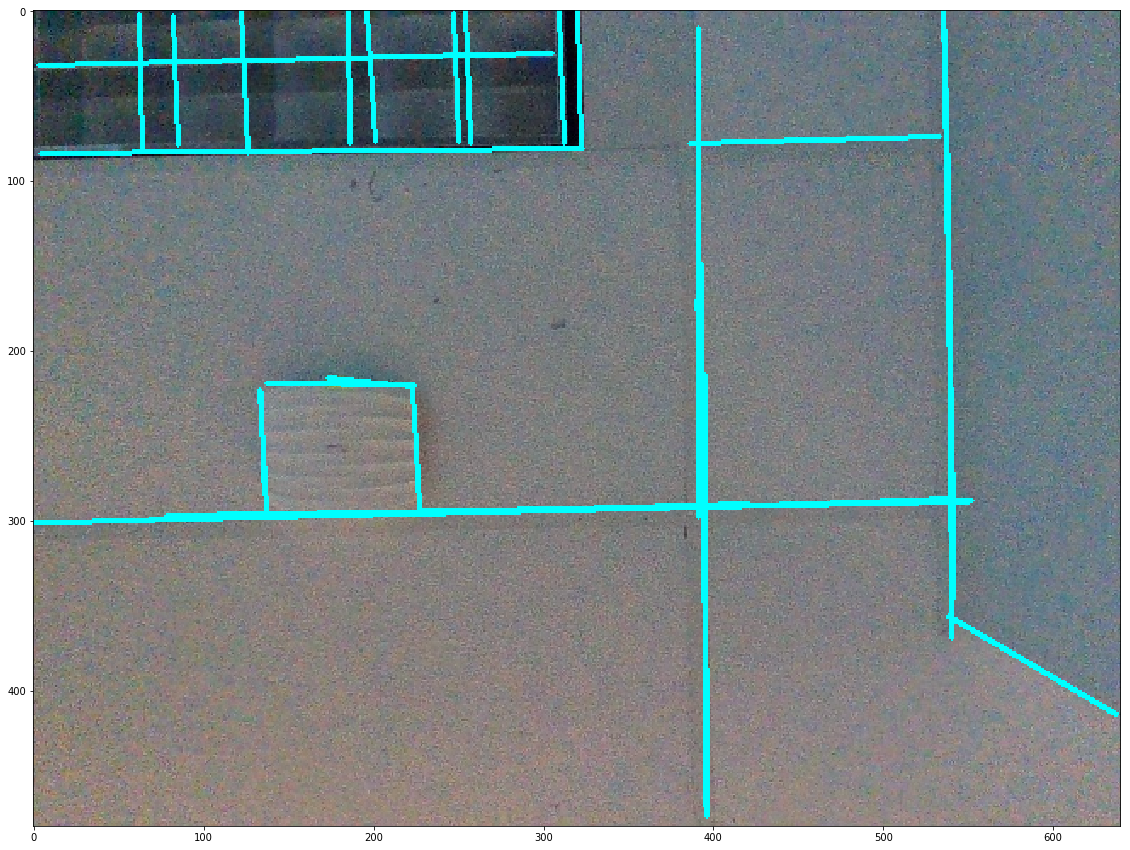

number of candidate lines: 25
Tracking the same best line...


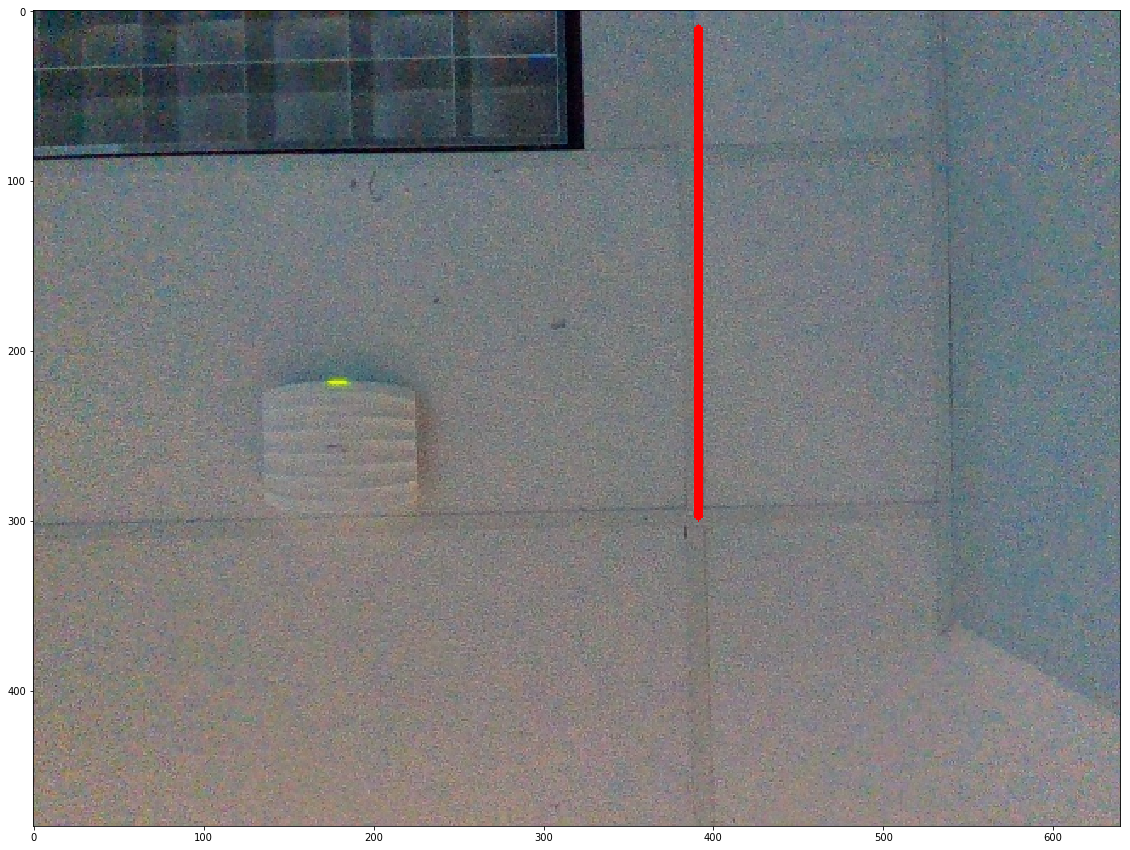

KeyboardInterrupt: Interrupted by user

In [38]:
prev_bestline=np.zeros(8)
for i in range(len(imgfiles)):
    cv_image=cv2.imread(imgfiles[i])
    #print(imgfiles[i])
    print("frame",i)
    line_segments=trt_mlsd.detect(cv_image,score_thr,dist_thr)
    if line_segments.shape[0]:
        print("Line Segments detected!")
        #print(line_segments.astype(int))
        print(line_segments.shape)
        img_lines=draw_lines(cv_image,line_segments)
        plt.figure(figsize=(30,15)) 
        plt.imshow(img_lines)
        plt.show()
    
        
    # line lines detection and process track error
     # Create MLSD line detection object
    line_detection_object = MLSDBestLineDetection(angle,tolerance)
    lines_info=line_detection_object.processSegments(line_segments)
    if i == 0:
        this_bestline, output_img, lines_info = line_detection_object.bestline_picker(cv_image,lines_info)
        print("Best line detected:")
        print(this_bestline)
        copy=np.copy(cv_image)
        output_img= line_detection_object.draw_bestline(copy, this_bestline)
        plt.figure(figsize=(30,15)) 
        plt.imshow(output_img)
        plt.show()

    else:
        if lines_info.shape[0]==0: # if there is no line segment detected
            print("No line segments detected!")
            this_bestline=np.zeros(8) # empty best line 
        else:
            this_bestline, pick_new_line = line_detection_object.pick_sameline(prev_bestline, lines_info)

            if pick_new_line: # if pick the new best line
                this_bestline, output_img, lines_info= line_detection_object.bestline_picker(cv_image,lines_info)
                print("Picking a new best line....")
                print("Ignoring the drift between two different best lines...")
            else:  # stick to the old best line (calculate drift)
                print("Tracking the same best line...")
                copy=np.copy(cv_image)
                output_img= line_detection_object.draw_bestline(copy, this_bestline)
                plt.figure(figsize=(30,15)) 
                plt.imshow(output_img)
                plt.show()
    
    prev_bestline=this_bestline
    input("Press Enter to continue...")